# Assignment 8: Exploration of our neural network in MNIST
In this assignment, I would like you to add some features to our neural network , and then use this to optimize its performance.

Tasks:

0. Get the data.  Do all of the tasks below for the "short" dataset. 
1. Get the code from the neural network notebook.   Modify the fit method to return:
- Train and test cost
- Train and test accuracy by epoch
   
2. When the training is done:
-  Plot the cost for test and train
-  Print out the confusion matrix
     
3.  Examine the performance (using accuracy) for this network as a function of the number of hidden nodes.  Try varying this from 10-200 in steps of 10.   Plot the accuracy for test and train as a function of hidden nodes.

Extra Credit:
1.  Add code to stop the training based on the cost of the test data set.
2.  This is much more involved: add another hidden layer to the network.   You will have to modify the forward pass as well as the backpropagation methods.


# Task 0a: Get the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical   
#
# Data location
data_location = '/fs/ess/PAS2038/PHYSICS5680_OSU/data'
#
# Define our "signal" digit
#short = ""
short = "short_"

#
# Read in all of the other digits
dfCombined = pd.DataFrame()
for digit in range(10):
    print("Processing digit ",digit)
    fname = data_location + '/ch3/digit_' + short + str(digit) + '.csv'
    df = pd.read_csv(fname,header=None)
    df['digit'] = digit
    dfCombined = pd.concat([dfCombined, df])

print("Length of sample:     ",len(dfCombined))
num_features = 784


Processing digit  0
Processing digit  1
Processing digit  2
Processing digit  3
Processing digit  4
Processing digit  5
Processing digit  6
Processing digit  7
Processing digit  8
Processing digit  9
Length of sample:      10000


# Task 0b: Make separate train and test samples

In [2]:
# Your code here.....
train_digits,test_digits = train_test_split(dfCombined, test_size=0.3, random_state=42)
yTrain = train_digits['digit'].values
XTrain = train_digits.iloc[:,:784].to_numpy()

yTest = test_digits['digit'].values
XTest = test_digits.iloc[:,:784].to_numpy()

# one hot encode the labels
num_classes = len(np.unique(yTrain))
print("Number distinct classes ",num_classes)
yTrain_oneHot = to_categorical(yTrain, num_classes=num_classes)
yTest_oneHot = to_categorical(yTest, num_classes=num_classes)
for i in range(10):
  print("digit ",yTrain[i],"encoding",yTrain_oneHot[i])

# We need to normalize our data - just divide by 256!
XTrain = XTrain/255.0
XTest = XTest / 255.0
#
print("XTrain",XTrain.shape)
print("XTest",XTest.shape)

Number distinct classes  10
digit  9 encoding [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
digit  2 encoding [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
digit  7 encoding [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
digit  1 encoding [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
digit  5 encoding [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
digit  5 encoding [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
digit  3 encoding [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
digit  0 encoding [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
digit  4 encoding [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
digit  6 encoding [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
XTrain (7000, 784)
XTest (3000, 784)


# Tasks 1: Get Code from Neural Network Notebook
Get the appropriate routines (sigmoid, sigmoid_deriv, forward_pass, etc) - **except for** "fit" and "getResults" methods.

In [3]:
def sigmoid(z):
  sm = 1.0 / (1.0 + np.exp(z))
  return sm

def sigmoid_deriv(z):
  sm = sigmoid(z)*(1-sigmoid(z))
  return sm

def tanh(z):
  return np.tanh(z)

def tanh_deriv(z):
  return 1 - np.square(np.tanh(z))

def softmaxNew(v):
  logC = -np.max(v)
  return np.exp(v + logC)/np.sum(np.exp(v + logC), axis = 1)[:,np.newaxis]

def calc_cost(yp_oneHot,output,w1,w2,Lambda=0.0):
  m = yp_oneHot.shape[0] #First we get the number of training examples
  cost = (-1 / m) * np.sum(yp_oneHot * np.log(output)) + (Lambda/2.0)*(np.sum(np.square(w1[:, 1:])) + np.sum(np.square(w2[:, 1:])))
  return cost 

def forward_pass(x, w1, w2):
#
#
# x: input matrix, dimension features by samples
# w1: weight matrix connecting input layer to hidden layer (takes place of earlier Theta matrix) 
#       ==> dimension hidden nodes by (features+1)
# w2: weight matrix connecting hidden layer to output layer (takes place of earlier Theta matrix) 
#       ==> dimension output nodes by (hidden nodes+1)
# a1: the "output" (also called the activation) of the input layer => just a copy of the input layer
#     we need to add the ones column which activates the boas
  ones = np.ones((len(x),1))
  a1 = np.append(ones,x,axis=1)
#
# z2: the input to the hidden layer = weight w1 matrix applied to (input features plus bias)
  z2 = a1.dot(w1.T)
        #print("z2.shape",z2.shape)
        #applies the tanh function to obtain the input mapped to a distrubution of values between -1 and 1
#
# The output of the hidden layer is the input passed through an "activation" function.  This can
# be sigmoid, tanh, relu, etc
  a2 = tanh(z2)
#
# Need to add "ones" column to this just like a1
  ones = np.ones((len(a2),1))
  a2 = np.append(ones,a2,axis=1)

#
# z3: the input to the output layer = weight w2 matrix applied to (a2 plus bias)  
  z3 = a2.dot(w2.T)
# 
# The "output" of the output layer is pass through the softmax activation
  a3 = softmaxNew(z3)
  return a1, z2, a2, z3, a3

def backpropMine(a1, a2, a3, z2, y_enc, w1, w2,Lambda):

#
  pJ_pa3__pa3_pz3 = (a3 - y_enc)
  pz3_pw2 = a2
#
# Pull it all together
  grad_w2 = pJ_pa3__pa3_pz3.T.dot(pz3_pw2)

  pz3_pa2 = w2
  ones = np.ones((len(z2),1))
  z2 = np.append(ones,z2,axis=1)
  pa2_pz2 = tanh_deriv(z2)
  pz2_pw1 = a1
  sigma2 = pJ_pa3__pa3_pz3.dot(pz3_pa2) * pa2_pz2
#
# Pull it all together
  grad_w1 = sigma2[:, 1:].T.dot(pz2_pw1)
#
# add the regularization term
  grad_w1[:, 1:]+= (w1[:, 1:]*Lambda) # derivative of .5*l2*w1^2
  grad_w2[:, 1:]+= (w2[:, 1:]*Lambda) # derivative of .5*l2*w2^2
  return grad_w1, grad_w2


# Task 2: Modify the fit method
Add the confusion matrix to the getResults routine, and return it in addition to the "classes" and "probs" results

In [4]:
import time
# This allows multidimensional counters (and other more complicated strucutres!)
from collections import defaultdict
from functools import partial
from itertools import repeat
def nested_defaultdict(default_factory, depth=1):
    result = partial(defaultdict, default_factory)
    for _ in repeat(None, depth - 1):
        result = partial(defaultdict, result)
    return result()

def getResults(X,y,w1,w2):
# Your code here
# Run a forward pass for our input data
    a1, z2, a2, z3, a3 = forward_pass(X, w1, w2)

# Our outut probability vector for each class is a3

# Get the max probabilites
    probs = np.max(a3, axis = 1)

# Get the predicted classes
    classes = np.argmax(a3, axis = 1)

# Get the confusion matrix
    confusion_matrix = nested_defaultdict(int,2)

    for ys,preds in zip(y,classes):
        #print(y,pred)
        confusion_matrix[ys][preds] += 1

    return classes,probs,confusion_matrix



# Task 3: Modify the fit method
Modify the fit method in the following way:
1.  Add XTest, y_test, y_test_oneHot to the cllin of the "fit" method.
2.  Modify the training cost calculation so that it is calculated **only** for each epcoh instead of each mini-batch.  This should be very easy - ask me if you are unsure how to do this!
3.  Add a cost calculation for the test data set as well (store in a list for each epoch).
4.  Add a calculation of the train and test average accuracy (store each in a list  for each epoh).

Return all of these as lists, along with the final w1 and w2.  In the skeleton code below, I put all of the lists into a dictionary to make it simpler.


In [5]:
def fit(X, y, y_oneHot, XTest, y_test, y_test_oneHot, n_hidden=100,epochs=100,numBatches=500,Lambda=0.0,learning_rate=0.001):
#
# Lists for returning results
    costs = []
    costs_test = []
    accuracies = []
    accuracies_test = []
    confs = []
    confs_test = []
#
# Your code here
    decay_rate=0.00001

# Get copies of the data
    X_data = X.copy()
    y_enc = y_oneHot.copy()
    
    X_test_data = XTest.copy()
    y_test_enc = y_test_oneHot.copy()
# Get the initial values
    m,n_features = X_data.shape   # this has the true "n" features 
    m,n_test_features = X_test_data.shape
    
# How many outputs do we have
    m,n_output = y_enc.shape
    m,n_test_output = y_test_enc.shape
#
# Initialize the weights to small random numbers
    w1 = np.random.uniform(-1.0, 1.0, size = n_hidden *(n_features + 1)).reshape(n_hidden, (n_features + 1))/(10.0*n_features + 1)
    w2 = np.random.uniform(-1.0, 1.0, size= n_output*(n_hidden+1)).reshape(n_output,n_hidden+ 1) /(10.0*n_hidden + 1)
    prev_grad_w1 = np.zeros(w1.shape)
    prev_grad_w2 = np.zeros(w2.shape)
# Run through the dataset some fixed number of epochs
    t0 = time.time()
    for i in range(epochs):
        learning_rate /= (1 + decay_rate*i)
#
# Split the data up into chunks
        mini = np.array_split(range(X_data.shape[0]), numBatches)
        print("epoch",i,'; time: ',time.time()-t0)
        t0 = time.time()
        for idx in mini:
# Forward pass
            a1, z2, a2, z3, a3= forward_pass(X_data[idx], w1, w2)
# compute gradient via backpropagation
            grad1, grad2 = backpropMine(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[idx], w1=w1, w2=w2, Lambda=Lambda)
            w1_update, w2_update = learning_rate*grad1, learning_rate*grad2
            w1 += -w1_update
            w2 += -w2_update
            prev_grad_w1, prev_grad_w2 = w1_update, w2_update
            
        a1, z2, a2, z3, a3= forward_pass(X_data, w1, w2)
        cost = calc_cost(y_enc, a3, w1, w2, Lambda=Lambda)
        costs.append(cost)
        # Train results
        classes,probs,conf = getResults(X,y,w1,w2)
        correct = 0
        for i in range(y.shape[0]):
          if y[i] == classes[i]:
            correct += 1
        acc = 100.0*correct / y.shape[0]
        accuracies.append(acc)
        confs.append(conf)

        # Test results
        a1, z2, a2, z3, a3= forward_pass(X_test_data, w1, w2)
        cost_test = calc_cost(y_test_enc, a3, w1, w2, Lambda=Lambda)
        costs_test.append(cost_test)
        classes_test,probs_test,conf_test = getResults(XTest,y_test,w1,w2)
        correct_test = 0
        for i in range(y_test.shape[0]):
          if y_test[i] == classes_test[i]:
            correct_test += 1
        acc_test = 100.0*correct_test / y_test.shape[0]
        accuracies_test.append(acc_test)
        confs_test.append(conf_test)
    

# Form the dictionary to return results
    history = {"costs_train":costs,"costs_test":costs_test,
                "accuracies_train":accuracies,"accuracies_test":accuracies_test,
                "conf_train":confs,"conf_test":confs_test
               }
#    
    return w1,w2,history

# Task 4: Run the algorithm
Use the following parameters:
1. 100 hidden nodes
2. 50 epochs
3. Batch size of 500

After the algoritm runs do the following:
1.  Plot the cost vs epoch for test and train.
2.  Plot the average accuracy vs epoch for test and train
3.  Print out the test confusion matrix for the final model.  To do this, just call getResults with the final w1, w2, and Xtest, and loop over the predicted classes.   We have done this a few times already, but ask if you have questions.

This part of the assignment should take about 5 minutes to run.

In [6]:
import time
n_hidden=100
epochs=50
learning_rate=0.001
batch_size = 500
numBatches=int(len(XTrain)/batch_size)
print(numBatches)

t00 = time.time()
w1,w2,history = fit(XTrain, yTrain, yTrain_oneHot, XTest, yTest, yTest_oneHot, n_hidden=n_hidden,epochs=epochs,numBatches=numBatches,learning_rate=learning_rate)


14
epoch 0 ; time:  0.0010287761688232422
epoch 1 ; time:  4.41066575050354
epoch 2 ; time:  4.899031162261963
epoch 3 ; time:  4.998689651489258
epoch 4 ; time:  4.807352781295776
epoch 5 ; time:  5.394328355789185
epoch 6 ; time:  5.395666599273682
epoch 7 ; time:  5.197822570800781
epoch 8 ; time:  4.912249803543091
epoch 9 ; time:  5.288895130157471
epoch 10 ; time:  5.697798728942871
epoch 11 ; time:  5.003853797912598
epoch 12 ; time:  5.299432754516602
epoch 13 ; time:  4.997123718261719
epoch 14 ; time:  5.401219367980957
epoch 15 ; time:  4.996987581253052
epoch 16 ; time:  5.100939989089966
epoch 17 ; time:  5.30110239982605
epoch 18 ; time:  5.001351594924927
epoch 19 ; time:  5.0045740604400635
epoch 20 ; time:  4.898981094360352
epoch 21 ; time:  4.997770071029663
epoch 22 ; time:  5.0024237632751465
epoch 23 ; time:  5.197545289993286
epoch 24 ; time:  4.902902364730835
epoch 25 ; time:  5.2004477977752686
epoch 26 ; time:  4.89755916595459
epoch 27 ; time:  5.30212163925

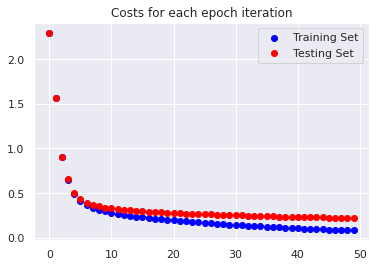

In [7]:
#costs
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

fig, ax = plt.subplots()

ax.scatter(np.arange(0,len(history['costs_train'])), history['costs_train'],label='Training Set', color='blue')
ax.scatter(np.arange(0,len(history['costs_test'])), history['costs_test'],label='Testing Set', color='red')
ax.legend()
ax.set_title('Costs for each epoch iteration')
plt.show()


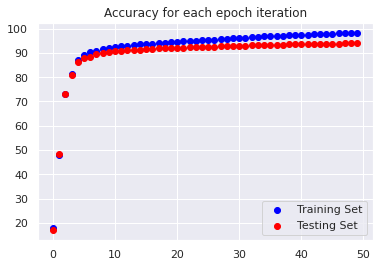

In [8]:
#accuracies

fig, ax = plt.subplots()

ax.scatter(np.arange(0,len(history['accuracies_train'])), history['accuracies_train'],label='Training Set', color='blue')
ax.scatter(np.arange(0,len(history['accuracies_test'])), history['accuracies_test'],label='Testing Set', color='red')
ax.legend()
ax.set_title('Accuracy for each epoch iteration')
plt.show()


In [9]:
#confusion matrix

dfc = pd.DataFrame.from_dict(history['conf_test'][len(history['conf_test']) - 1],orient='index')
dfc = dfc.fillna(0)
dfc.sort_index(axis=0,inplace=True)
dfc.sort_index(axis=1,inplace=True)
#
# Print the dataframe as a table to see what it looks like
print("Rows are true classes, columns are predicted classes:")
display(dfc)

Rows are true classes, columns are predicted classes:


,0,1,2,3,4,5,6,7,8,9
0,309.0,0.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,0.0
1,0.0,302.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0
2,1.0,3.0,262.0,3.0,3.0,2.0,3.0,3.0,7.0,1.0
3,0.0,6.0,12.0,269.0,0.0,11.0,0.0,2.0,1.0,2.0
4,0.0,2.0,2.0,0.0,304.0,0.0,3.0,0.0,1.0,8.0
5,2.0,0.0,0.0,7.0,2.0,270.0,2.0,2.0,4.0,1.0
6,4.0,2.0,4.0,0.0,2.0,4.0,275.0,0.0,1.0,0.0
7,0.0,1.0,3.0,2.0,2.0,0.0,0.0,279.0,0.0,5.0
8,2.0,6.0,5.0,4.0,1.0,6.0,1.0,0.0,299.0,0.0
9,1.0,0.0,0.0,0.0,10.0,0.0,0.0,4.0,0.0,250.0


# Task 5: Optimize for number of hidden nodes:
Make a loop over hidden nodes, doing at least the following nodes: 5,15,30,60,100,150.    Store the final accuracy for test and train for each node choice in a list.   The "final" accuracy for both test and train should be the last element in the lists returned from the "fit" method.  

Plot these accuracies vs hidden nodes.   

Each node choice will take about 2-6 minutes (less for fewer hidden nodes, more for higher numbers of hidden nodes), so the total time (assuming the above 6 node choices) will take about 25-30 minutes.   Make sure you have at least that much time left to save your results.   

In [10]:
epochs=50
learning_rate=0.001
batch_size = 1000
numBatches=int(len(XTrain)/batch_size)
print(numBatches)

accuracy_list_train = []
accuracy_list_test = []
hidden_list = [5,15,30,60,100,150]

for n_hidden in hidden_list:
    print("Hidden nodes:",n_hidden)
    w1,w2,history = fit(XTrain, yTrain, yTrain_oneHot, XTest, yTest, yTest_oneHot, n_hidden=n_hidden,epochs=epochs,numBatches=numBatches,learning_rate=learning_rate)
    accuracy_list_train.append(history['accuracies_train'][-1])
    accuracy_list_test.append(history['accuracies_test'][-1])

7
Hidden nodes: 5
epoch 0 ; time:  0.0012576580047607422
epoch 1 ; time:  1.6326947212219238
epoch 2 ; time:  1.7896287441253662
epoch 3 ; time:  1.8050291538238525
epoch 4 ; time:  2.694040060043335
epoch 5 ; time:  1.8004939556121826
epoch 6 ; time:  1.7002527713775635
epoch 7 ; time:  1.909377098083496
epoch 8 ; time:  1.4889655113220215
epoch 9 ; time:  1.5058677196502686
epoch 10 ; time:  1.694230556488037
epoch 11 ; time:  1.4996998310089111
epoch 12 ; time:  1.699559211730957
epoch 13 ; time:  1.599184513092041
epoch 14 ; time:  1.7004871368408203
epoch 15 ; time:  1.7988276481628418
epoch 16 ; time:  1.599949598312378
epoch 17 ; time:  1.602647304534912
epoch 18 ; time:  1.6060240268707275
epoch 19 ; time:  1.890453577041626
epoch 20 ; time:  1.599059820175171
epoch 21 ; time:  1.6003766059875488
epoch 22 ; time:  1.6990609169006348
epoch 23 ; time:  1.405808448791504
epoch 24 ; time:  1.7003858089447021
epoch 25 ; time:  1.9013075828552246
epoch 26 ; time:  1.6988461017608643


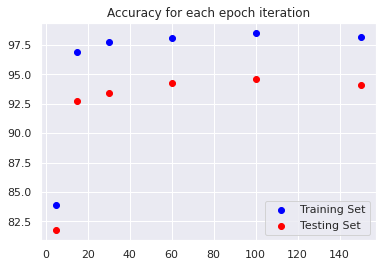

In [11]:
fig, ax = plt.subplots()

ax.scatter(hidden_list, accuracy_list_train,label='Training Set', color='blue')
ax.scatter(hidden_list, accuracy_list_test,label='Testing Set', color='red')
ax.legend()
ax.set_title('Accuracy for each epoch iteration')
plt.show()

# Extra #1: Add code to stop the training based on the cost of the test data set (1 point)
Call this new method "fit_cost".   You want to stop the training if the change in cost in the test set is less than some amount (try 0.002), as long as the number of epochs is greater than some mininum (try 10).

Do this for 100 hidden nodes.   What epoch does it stop at?

In [12]:
def fit_cost(X, y, y_oneHot, XTest, y_test, y_test_oneHot, n_hidden=100,delta_cost=0.002,min_epochs=10,epochs=100,numBatches=500,Lambda=0.0,learning_rate=0.001):#
#
# Lists for returning results
    costs = []
    costs_test = []
    accuracies = []
    accuracies_test = []
    confs = []
    confs_test = []
    actual_epochs = []
#
# Your code here
    decay_rate=0.00001

# Get copies of the data
    X_data = X.copy()
    y_enc = y_oneHot.copy()
    
    X_test_data = XTest.copy()
    y_test_enc = y_test_oneHot.copy()
# Get the initial values
    m,n_features = X_data.shape   # this has the true "n" features 
    m,n_test_features = X_test_data.shape
    
# How many outputs do we have
    m,n_output = y_enc.shape
    m,n_test_output = y_test_enc.shape
#
# Initialize the weights to small random numbers
    w1 = np.random.uniform(-1.0, 1.0, size = n_hidden *(n_features + 1)).reshape(n_hidden, (n_features + 1))/(10.0*n_features + 1)
    w2 = np.random.uniform(-1.0, 1.0, size= n_output*(n_hidden+1)).reshape(n_output,n_hidden+ 1) /(10.0*n_hidden + 1)
    prev_grad_w1 = np.zeros(w1.shape)
    prev_grad_w2 = np.zeros(w2.shape)
# Run through the dataset some fixed number of epochs
    t0 = time.time()
    i = 0
    delta = 10000 #this is some random value to initialize delta and have the while loop work
    #for i in range(epochs):
    while((i < epochs) and not((i > 10) and (delta < delta_cost))):
        learning_rate /= (1 + decay_rate*i)
#
# Split the data up into chunks
        mini = np.array_split(range(X_data.shape[0]), numBatches)
        print("epoch",i,'; time: ',time.time()-t0)
        t0 = time.time()
        for idx in mini:
# Forward pass
            a1, z2, a2, z3, a3= forward_pass(X_data[idx], w1, w2)
# compute gradient via backpropagation
            grad1, grad2 = backpropMine(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[idx], w1=w1, w2=w2, Lambda=Lambda)
            w1_update, w2_update = learning_rate*grad1, learning_rate*grad2
            w1 += -w1_update
            w2 += -w2_update
            prev_grad_w1, prev_grad_w2 = w1_update, w2_update
            
        a1, z2, a2, z3, a3= forward_pass(X_data, w1, w2)
        cost = calc_cost(y_enc, a3, w1, w2, Lambda=Lambda)
        costs.append(cost)
        # Train results
        classes,probs,conf = getResults(X,y,w1,w2)
        correct = 0
        for j in range(y.shape[0]):
          if y[j] == classes[j]:
            correct += 1
        acc = 100.0*correct / y.shape[0]
        accuracies.append(acc)
        confs.append(conf)

        # Test results
        a1, z2, a2, z3, a3= forward_pass(X_test_data, w1, w2)
        cost_test = calc_cost(y_test_enc, a3, w1, w2, Lambda=Lambda)
        costs_test.append(cost_test)
        classes_test,probs_test,conf_test = getResults(XTest,y_test,w1,w2)
        correct_test = 0
        for j in range(y_test.shape[0]):
          if y_test[j] == classes_test[j]:
            correct_test += 1
        acc_test = 100.0*correct_test / y_test.shape[0]
        accuracies_test.append(acc_test)
        confs_test.append(conf_test)
        
        actual_epochs.append(i)
        if i != 0:
            delta = np.abs(costs_test[i] - costs_test[i-1])
        i += 1
    
    history = {"actual_epochs":actual_epochs,"costs_train":costs,"costs_test":costs_test,
                               "accuracies_train":accuracies,"accuracies_test":accuracies_test,
                               "conf_train":confs,"conf_test":confs_test
                               }
    
    return w1,w2,history

In [13]:
import time
n_hidden=100
epochs_max=50
delta_cost=0.002
min_epochs=10
learning_rate=0.001
batch_size = 1000
numBatches=int(len(XTrain)/batch_size)
print(numBatches)

t00 = time.time()
w1,w2,history = fit_cost(XTrain, yTrain, yTrain_oneHot, XTest, yTest, yTest_oneHot, n_hidden=n_hidden,delta_cost=delta_cost,min_epochs=min_epochs,epochs=epochs_max,numBatches=numBatches,learning_rate=learning_rate)
lastAcc_train = history["accuracies_train"][-1]
lastAcc_test = history["accuracies_test"][-1]
print("Training time ",round(time.time()-t00,3))
print("Actual epochs ",history["actual_epochs"])
print("last train accuracy ",lastAcc_train)
print("last test accuracy  ",lastAcc_test)

lastConf_test = history["conf_test"][-1]
for trueClass in range(10):
    print("True: ",trueClass,end="")
    for predClass in range(10):
        print("\t",lastConf_test[trueClass][predClass],end="")
    print()
print()


7
epoch 0 ; time:  0.0009534358978271484
epoch 1 ; time:  3.840564727783203
epoch 2 ; time:  4.192749500274658
epoch 3 ; time:  4.500795125961304
epoch 4 ; time:  4.200406789779663
epoch 5 ; time:  4.606360912322998
epoch 6 ; time:  4.198981046676636
epoch 7 ; time:  4.301112651824951
epoch 8 ; time:  4.402830123901367
epoch 9 ; time:  4.896743535995483
epoch 10 ; time:  4.0984885692596436
epoch 11 ; time:  4.209105014801025
epoch 12 ; time:  4.302404880523682
epoch 13 ; time:  4.601274251937866
epoch 14 ; time:  4.090819835662842
epoch 15 ; time:  4.201431512832642
epoch 16 ; time:  3.907484292984009
epoch 17 ; time:  4.294335842132568
epoch 18 ; time:  4.2018349170684814
epoch 19 ; time:  4.998575210571289
epoch 20 ; time:  5.094722509384155
epoch 21 ; time:  4.799201965332031
epoch 22 ; time:  4.507915019989014
epoch 23 ; time:  4.995283603668213
epoch 24 ; time:  4.40497088432312
epoch 25 ; time:  4.695330619812012
epoch 26 ; time:  5.010013818740845
epoch 27 ; time:  4.89997363090

with 100 hidden nodes, we stop at epoch 30

# Extra, #2: Adding another hidden layer (2 points)

You will need to make the following new routines:
1.  getResults_3
2.  calc_cost_3
3. forward_pass_3
4. backpropMine_3
5.  fit_3

Test this with the following parameters:
- epochs 50 (if you did extra credit #1 use the "early stopping" method from that)
- hidden nodes layer 1: 80
- hidden nodes layer 2: 20
- batch size 500

Produce the following:
1.  Cost vs iteration
2.  Accuracy vs iteration
3.  Confusion matrix